In [1]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools

# Get Data 
---

In [2]:
#XVS/USDT_2024_30m & QI/USDT_2024_30m

In [3]:
prices = pd.read_csv("binance_data/Wrapped BTC/2024/30m/merged_closing_prices.csv", index_col=0, parse_dates=True)

In [4]:
prices

,BTC/USDT_2024_30m,WBTC/USDT_2024_30m
timestamp,,
2024-01-01 00:00:00,42419.73,42394.30
2024-01-01 00:30:00,42475.23,42444.16
2024-01-01 01:00:00,42493.16,42431.64
2024-01-01 01:30:00,42613.56,42616.90
2024-01-01 02:00:00,42546.01,42458.23
...,...,...
2024-12-31 21:30:00,93899.68,93748.37
2024-12-31 22:00:00,93722.23,93553.89
2024-12-31 22:30:00,93488.84,93329.48


# Trading simulation
---

* ## In-Sample Testing

In [5]:
#XVS/USDT_2024_30m & QI/USDT_2024_30m
cointegrated_pairs = [('BTC/USDT_2024_30m',
  'WBTC/USDT_2024_30m',
  0.731393,
  0.8501886494196308,
  0.22)]

In [6]:
#Params:
window_size = 336
entry_threshold=1.0 
exit_threshold=0.1 
stop_loss_threshold=2.0

In [7]:
if cointegrated_pairs:
        sym1, sym2, pass_fraction, avg_p_value,correlation = cointegrated_pairs[0]
        print(f"\nTesting strategy on pair: {sym1} and {sym2} (pass_fractioon: {pass_fraction:.4f},average_p_value: {avg_p_value:.4f} correlation: {correlation:.4f})")
        S1 = prices[sym1]
        S2 = prices[sym2]
        
        # Compute the spread series and beta_series 
        spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
        #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")
        
        # Compute rolling z-score using the provided helper function.
        zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)
        
        # Generate trading signals (positions) based on the spread's z-score
        positions_series,  win_indexs, loss_indexs, price_changes_S1, price_changes_S2 = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)

        #Simulate strategy performance
        #pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)

        #pnl, cum_pnl = simulate_true_strategy_rolling(S1, S2, positions_series, beta_series)
        


Testing strategy on pair: BTC/USDT_2024_30m and WBTC/USDT_2024_30m (pass_fractioon: 0.7314,average_p_value: 0.8502 correlation: 0.2200)
Total trades closed: 1427 (Wins=1215, Losses=212)
Win rate: 0.85


In [8]:
daily_pnl_series, cum_pnl_series, cum_pnl_pct_series, shares_S1_list, shares_S2_list = simulate_strategy_pnl(S1, S2, positions_series, beta_series=beta_series, initial_capital=1_000)

print(f"Total PnL: {cum_pnl_series[-1]:.2f} EUR")
print(f"Total PnL (%): {cum_pnl_pct_series[-1]:.2f}%")


Total PnL: 872.43 EUR
Total PnL (%): 87.24%


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_17388/548679118.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Total PnL: {cum_pnl_series[-1]:.2f} EUR")
/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_17388/548679118.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Total PnL (%): {cum_pnl_pct_series[-1]:.2f}%")


Average daily PnL (BY EXLUDING THE 0 ENTRIES): 0.18 EUR
Average daily PnL (%): 0.00%


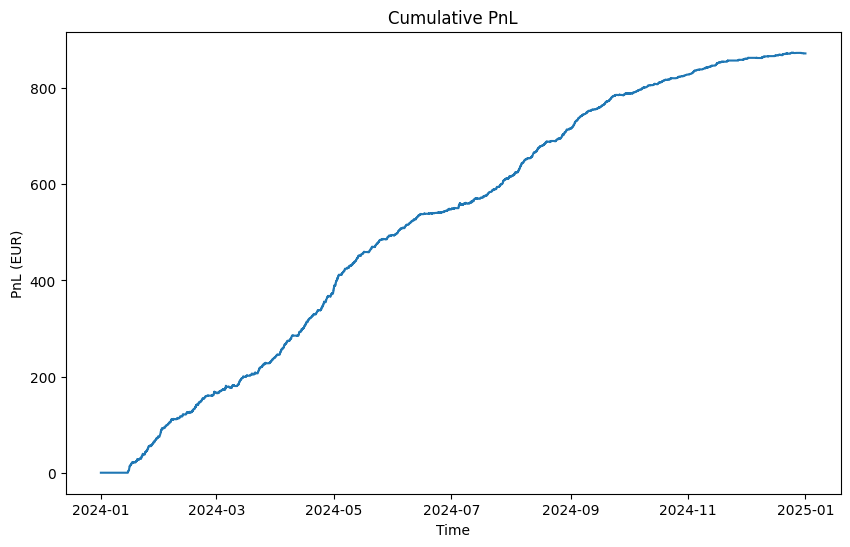

In [9]:
#Plot the cumulative PnL

print(f"Average daily PnL (BY EXLUDING THE 0 ENTRIES): {daily_pnl_series[daily_pnl_series != 0].mean():.2f} EUR")
print(f"Average daily PnL (%): {daily_pnl_series[daily_pnl_series != 0].mean() / 1000:.2f}%")

#PROFIT SHOULD BE 0.15 EUR

plt.figure(figsize=(10,6))
plt.plot(cum_pnl_series)
plt.title('Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('PnL (EUR)')
plt.show()

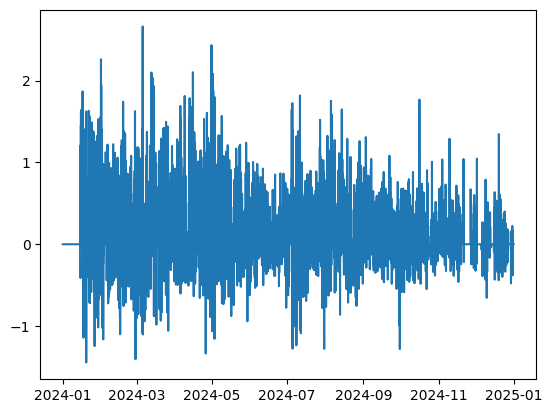

In [10]:
plt.plot(daily_pnl_series)

In [11]:
#Sum profits that dont equal zero

daily_pnl_series[daily_pnl_series != 0].mean()


np.float64(0.17977026658550943)

Long Entries In Window: 6, Short Entries In Window: 2
Wins In Window: 8, Losses In Window: 0


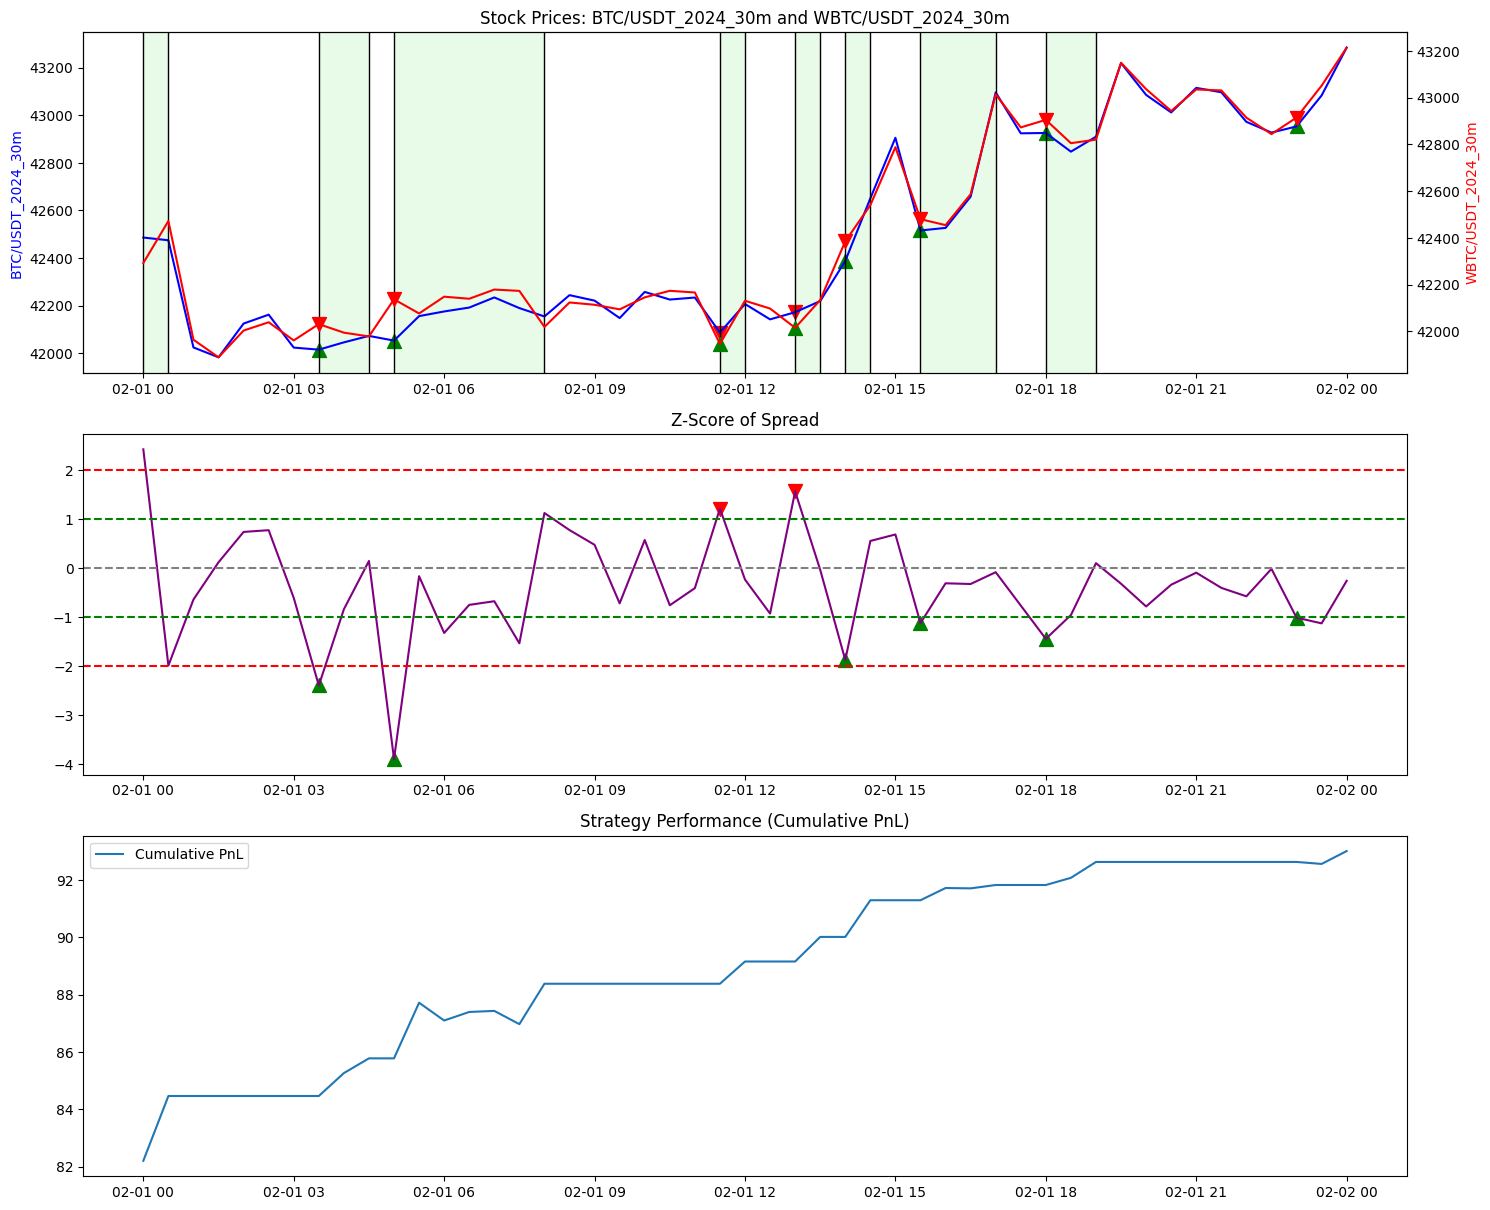

In [12]:
#Plot trading simulation
# window_start = '2023-10-03 00:00:00'
# window_end = '2023-10-03 10:00:00'


window_start = '2024-02-01 00:00:00'
window_end = '2024-02-02 00:00:00'

# window_start = None
# window_end = None

#NOTE THAT THE TIMES ON THE X AXIS SHOW THE HOURS AND MINUTES


plot_trading_simulation(S1, S2, sym1,sym2,zscore_series, positions_series, 
                        cum_pnl_series,win_indexs=win_indexs,loss_indexs=loss_indexs,
                        window_start=window_start, window_end=window_end)



In [13]:
print(cum_pnl_series.loc[window_start:window_end])

timestamp
2024-02-01 00:00:00    82.200161
2024-02-01 00:30:00    84.461675
2024-02-01 01:00:00    84.461675
2024-02-01 01:30:00    84.461675
2024-02-01 02:00:00    84.461675
2024-02-01 02:30:00    84.461675
2024-02-01 03:00:00    84.461675
2024-02-01 03:30:00    84.461675
2024-02-01 04:00:00    85.261804
2024-02-01 04:30:00    85.776008
2024-02-01 05:00:00    85.776008
2024-02-01 05:30:00    87.717785
2024-02-01 06:00:00    87.096098
2024-02-01 06:30:00    87.395032
2024-02-01 07:00:00    87.431748
2024-02-01 07:30:00    86.969855
2024-02-01 08:00:00    88.380017
2024-02-01 08:30:00    88.380017
2024-02-01 09:00:00    88.380017
2024-02-01 09:30:00    88.380017
2024-02-01 10:00:00    88.380017
2024-02-01 10:30:00    88.380017
2024-02-01 11:00:00    88.380017
2024-02-01 11:30:00    88.380017
2024-02-01 12:00:00    89.156299
2024-02-01 12:30:00    89.156299
2024-02-01 13:00:00    89.156299
2024-02-01 13:30:00    90.014533
2024-02-01 14:00:00    90.014533
2024-02-01 14:30:00    91.294971


In [14]:
# plt.plot(spread_series.loc[window_start:window_end])
# plt.title('Spread Over Time')
# plt.legend()

In [15]:
#zip S1 and S2 together
S1_window = S1.loc[window_start:window_end]
S2_window = S2.loc[window_start:window_end]

#2023-10-23 22:43:00   -20.599535
#compute spread

rolling_mean_window = rolling_mean.loc[window_start:window_end]

rolling_std_window = rolling_std.loc[window_start:window_end]

spread_series_window = spread_series.loc[window_start:window_end]

alpha_series_window = alpha_series.loc[window_start:window_end]

z_score_window = zscore_series.loc[window_start:window_end]

beta_series_window = beta_series.loc[window_start:window_end]

#Merge dataframes together

merged_df = pd.concat([S1_window,S2_window,spread_series_window,rolling_mean_window,rolling_std_window,alpha_series_window,z_score_window,beta_series_window],axis=1)

merged_df.columns = ['S1','S2','Spread','Rolling Mean','Rolling Std','Alpha','Z Score','Beta']

merged_df

,S1,S2,Spread,Rolling Mean,Rolling Std,Alpha,Z Score,Beta
timestamp,,,,,,,,
2024-02-01 00:00:00,42486.40,42292.63,112.344064,6.718194,43.571431,54.831169,2.424200,1.000629
2024-02-01 00:30:00,42474.95,42472.47,-79.506369,7.270464,43.730919,67.467432,-1.984336,1.000342
2024-02-01 01:00:00,42025.00,41964.51,-21.072779,6.958793,43.975139,70.975248,-0.637441,1.000252
2024-02-01 01:30:00,41983.54,41889.37,12.432077,7.078886,43.842732,85.606436,0.122100,0.999908
2024-02-01 02:00:00,42125.23,42003.85,39.571664,7.105403,43.843268,88.969651,0.740507,0.999830
2024-02-01 02:30:00,42162.56,42039.35,41.248903,7.208226,43.878868,91.914485,0.775787,0.999763
2024-02-01 03:00:00,42024.30,41961.60,-19.310547,7.175721,43.849496,84.854655,-0.604027,0.999932
2024-02-01 03:30:00,42015.65,42031.40,-97.743497,7.106643,43.872949,88.261912,-2.389859,0.999851
2024-02-01 04:00:00,42046.30,41994.80,-30.214538,6.762694,44.240148,89.397554,-0.835830,0.999817


In [16]:
# window_start = '2023-10-23 21:20:00'
# window_end = '2023-10-23 22:50:00'

# #Time of event: 2023-10-23 22:43:00	

# S1_window = S1[window_start:window_end]
# S2_window = S2[window_start:window_end]

# #Plot time series from window start to window end on different y axis and show data points



# fig, ax1 = plt.subplots()

# #Set size of the plot
# fig.set_size_inches(12, 8)

# color = 'tab:red'
# ax1.set_xlabel('Time')
# ax1.set_ylabel('S1', color=color)
# ax1.plot(S1_window, color=color, marker='o')
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# color = 'tab:blue'  
# ax2.set_ylabel('S2', color=color)
# ax2.plot(S2_window, color=color, marker='o')
# ax2.tick_params(axis='y', labelcolor=color)

# plt.title('Time series of S1 and S2 from window start to window end')






# # plt.plot(S1_window)
# # plt.plot(S2_window)
# # plt.title('Time series of S1 and S2 from window start to window end')
# # plt.show()

In [17]:
# spre = 31971.76 - (-2.096653) - 1.151277 * 28349.60
# spre